# <center>CleverHans Blackbox Attack on MNIST</center>

This is a Jupyter Notebook implementation of the Cleverhans Blackbox Tutorial for presentation purposes.

This tutorial demonstrates the steps required to craft a blackbox attack on a remote model.

The original implementation is available in the [CleverHans github repo](https://github.com/tensorflow/cleverhans/blob/master/cleverhans_tutorials/mnist_blackbox.py).

In [0]:
#Adding the CleverHans dependencies to the environment
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

In [0]:
from __future__ import print_function,division,unicode_literals,absolute_import
%matplotlib inline
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
import numpy as np
import seaborn as sns
import logging

from six.moves import xrange
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils import to_categorical
from cleverhans.utils import set_log_level
from cleverhans.utils_tf import model_train, model_eval, batch_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks_tf import jacobian_graph, jacobian_augmentation

from cleverhans_tutorials.tutorial_models import make_basic_cnn, MLP
from cleverhans_tutorials.tutorial_models import Flatten, Linear, ReLU, Softmax
from cleverhans.utils import TemporaryLogLevel

## Create a Model to Serve as our Remote Blackbox

We don't have a remote blackbox model to test on so we will create a new model to treat as a blackbox. 

For this example we are creating a blackbox using the built-in *make_basic_cnn* function provided in the CleverHans library. This blackbox is a convolutional neural network that takes in a hand-written text and outputs the corresponding number to that text.

In [0]:
def prep_bbox(sess, x, y, X_train, Y_train, X_test, Y_test,
              nb_epochs, batch_size, learning_rate,
              rng):
    """
    Define and train a model that simulates the "remote"
    black-box oracle described in the original paper.
    :param sess: the TF session
    :param x: the input placeholder for MNIST
    :param y: the ouput placeholder for MNIST
    :param X_train: the training data for the oracle
    :param Y_train: the training labels for the oracle
    :param X_test: the testing data for the oracle
    :param Y_test: the testing labels for the oracle
    :param nb_epochs: number of epochs to train model
    :param batch_size: size of training batches
    :param learning_rate: learning rate for training
    :param rng: numpy.random.RandomState
    :return:
    """

    # Define TF model graph (for the black-box model)
    model = make_basic_cnn()
    predictions = model(x)
    print("Defined TensorFlow model graph.")

    # Train an MNIST model
    train_params = {
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
    model_train(sess, x, y, predictions, X_train, Y_train,
                args=train_params, rng=rng)

    # Print out the accuracy on legitimate data
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy of black-box on legitimate test '
          'examples: ' + str(accuracy))

    return model, predictions, accuracy

## Simulate the Remote Blackbox with a Substitute Model

The first step of the attack is to create a substitute model that will be trained based on predictions from the blackbox model.

The substitute model does not have to have the same structure as the blackbox.



In [0]:
def substitute_model(img_rows=28, img_cols=28, nb_classes=10):
    """
    Defines the model architecture to be used by the substitute. Use
    the example model interface.
    :param img_rows: number of rows in input
    :param img_cols: number of columns in input
    :param nb_classes: number of classes in output
    :return: tensorflow model
    """
    input_shape = (None, img_rows, img_cols, 1)

    # Define a fully connected model (it's different than the black-box)
    layers = [Flatten(),
              Linear(200),
              ReLU(),
              Linear(200),
              ReLU(),
              Linear(nb_classes),
              Softmax()]

    return MLP(layers, input_shape)

Training our substitution model involves using Jacobian-based dataset augmentation to increase the number of samples by querying the blackbox on the datapoints that change the most.

In [0]:
def train_sub(sess, x, y, bbox_preds, X_sub, Y_sub, nb_classes,
              nb_epochs_s, batch_size, learning_rate, data_aug, lmbda,
              rng):
    """
    This function creates the substitute by alternatively
    augmenting the training data and training the substitute.
    :param sess: TF session
    :param x: input TF placeholder
    :param y: output TF placeholder
    :param bbox_preds: output of black-box model predictions
    :param X_sub: initial substitute training data
    :param Y_sub: initial substitute training labels
    :param nb_classes: number of output classes
    :param nb_epochs_s: number of epochs to train substitute model
    :param batch_size: size of training batches
    :param learning_rate: learning rate for training
    :param data_aug: number of times substitute training data is augmented
    :param lmbda: lambda from arxiv.org/abs/1602.02697
    :param rng: numpy.random.RandomState instance
    :return:
    """
    # Define TF model graph (for the black-box model)
    model_sub = substitute_model()
    preds_sub = model_sub(x)
    print("Defined TensorFlow model graph for the substitute.")

    # Define the Jacobian symbolically using TensorFlow
    grads = jacobian_graph(preds_sub, x, nb_classes)

    # Train the substitute and augment dataset alternatively
    for rho in xrange(data_aug):
        print("Substitute training epoch #" + str(rho))
        train_params = {
            'nb_epochs': nb_epochs_s,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }
        with TemporaryLogLevel(logging.WARNING, "cleverhans.utils.tf"):
            model_train(sess, x, y, preds_sub, X_sub,
                        to_categorical(Y_sub, nb_classes),
                        init_all=False, args=train_params, rng=rng)

        # If we are not at last substitute training iteration, augment dataset
        if rho < data_aug - 1:
            print("Augmenting substitute training data.")
            # Perform the Jacobian augmentation
            lmbda_coef = 2 * int(int(rho / 3) != 0) - 1
            X_sub = jacobian_augmentation(sess, x, X_sub, Y_sub, grads,
                                          lmbda_coef * lmbda)

            print("Labeling substitute training data.")
            # Label the newly generated synthetic points using the black-box
            Y_sub = np.hstack([Y_sub, Y_sub])
            X_sub_prev = X_sub[int(len(X_sub)/2):]
            eval_params = {'batch_size': batch_size}
            bbox_val = batch_eval(sess, [x], [bbox_preds], [X_sub_prev],
                                  args=eval_params)[0]
            # Note here that we take the argmax because the adversary
            # only has access to the label (not the probabilities) output
            # by the black-box model
            Y_sub[int(len(X_sub)/2):] = np.argmax(bbox_val, axis=1)

    return model_sub, preds_sub

# Craft Adversarial Examples Using the Substitute Model

In [0]:
# Setting the parameters to use in our training 
# Index of the first training set example
train_start=0
# Index of the last training set example
train_end=60000
# Index of the first test set example
test_start=0
# Index of the last test set example
test_end=10000
nb_classes=10
batch_size=128
learning_rate=0.001
nb_epochs=10
holdout=150
data_aug=6
nb_epochs_s=10
lmbda=0.1

Start by initializing the parameters we will need to run our attack. 

The blackbox we created earlier is created and trained.



Preparing the black-box model.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Defined TensorFlow model graph.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



[INFO 2018-06-19 00:21:06,547 cleverhans] Epoch 0 took 154.99071836471558 seconds
[INFO 2018-06-19 00:23:41,920 cleverhans] Epoch 1 took 155.3639657497406 seconds
[INFO 2018-06-19 00:26:17,023 cleverhans] Epoch 2 took 155.09301280975342 seconds
[INFO 2018-06-19 00:28:53,026 cleverhans] Epoch 3 took 155.98964095115662 seconds
[INFO 2018-06-19 00:31:26,685 cleverhans] Epoch 4 took 153.64335536956787 seconds
[INFO 2018-06-19 00:34:01,340 cleverhans] Epoch 5 took 154.64132237434387 seconds
[INFO 2018-06-19 00:36:36,266 cleverhans] Epoch 6 took 154.91804432868958 seconds
[INFO 2018-06-19 00:39:11,040 cleverhans] Epoch 7 took 154.75997519493103 seconds
[INFO 2018-06-19 00:41:46,380 cleverhans] Epoch 8 took 155.32668542861938 seconds
[INFO 2018-06-19 00:44:23,370 cleverhans] Epoch 9 took 156.9770529270172 seconds
[INFO 2018-06-19 00:44:23,372 cleverhans] Completed model training.


Test accuracy of black-box on legitimate test examples: 0.9908629441624366


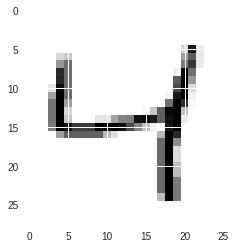

In [9]:
# Set logging level to see debug information
set_log_level(logging.DEBUG)

# Dictionary used to keep track and return key accuracies
accuracies = {}

# Create TF session
sess = tf.Session()

# Get MNIST data
X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                                  train_end=train_end,
                                                  test_start=test_start,
                                                  test_end=test_end)

# Initialize substitute training set reserved for adversary
X_sub = X_test[:holdout]
Y_sub = np.argmax(Y_test[:holdout], axis=1)

# Redefine test set as remaining samples unavailable to adversaries
X_test = X_test[holdout:]
Y_test = Y_test[holdout:]

# Define input and output TF placeholders
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

# Seed random number generator so tutorial is reproducible
rng = np.random.RandomState([2017, 8, 30])

# Simulate the black-box model locally
# You could replace this by a remote labeling API for instance
print("Preparing the black-box model.")
prep_bbox_out = prep_bbox(sess, x, y, X_train, Y_train, X_test, Y_test,
                              nb_epochs, batch_size, learning_rate,
                              rng=rng)
model, bbox_preds, accuracies['bbox'] = prep_bbox_out

# Print out some example inputs to the model
for idx in enumerate(random.sample(range(50),10)): 
    plt.imshow(X_train[idx].reshape(28,28))

![DNN Substitute Model Training](https://i.imgur.com/txzJQVf.png)

Now we are going to train our substitute model using the method shown above from [Practical Black-Box Attacks against Machine Learning
](https://arxiv.org/abs/1602.02697). In this method the blackbox is labeleld as the Oracle.

In [10]:
# Train substitute using method from https://arxiv.org/abs/1602.02697
print("Training the substitute model.")
train_sub_out = train_sub(sess, x, y, bbox_preds, X_sub, Y_sub,
                              nb_classes, nb_epochs_s, batch_size,
                              learning_rate, data_aug, lmbda, rng=rng)
model_sub, preds_sub = train_sub_out

Training the substitute model.
Defined TensorFlow model graph for the substitute.
Substitute training epoch #0


[INFO 2018-06-19 00:50:57,723 cleverhans] Epoch 0 took 0.04448103904724121 seconds
[INFO 2018-06-19 00:50:57,740 cleverhans] Epoch 1 took 0.014891862869262695 seconds
[INFO 2018-06-19 00:50:57,751 cleverhans] Epoch 2 took 0.010496377944946289 seconds
[INFO 2018-06-19 00:50:57,763 cleverhans] Epoch 3 took 0.009918928146362305 seconds
[INFO 2018-06-19 00:50:57,776 cleverhans] Epoch 4 took 0.011343955993652344 seconds
[INFO 2018-06-19 00:50:57,788 cleverhans] Epoch 5 took 0.011271238327026367 seconds
[INFO 2018-06-19 00:50:57,800 cleverhans] Epoch 6 took 0.010257244110107422 seconds
[INFO 2018-06-19 00:50:57,812 cleverhans] Epoch 7 took 0.009504079818725586 seconds
[INFO 2018-06-19 00:50:57,821 cleverhans] Epoch 8 took 0.00816035270690918 seconds
[INFO 2018-06-19 00:50:57,831 cleverhans] Epoch 9 took 0.008731365203857422 seconds
[INFO 2018-06-19 00:50:57,832 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #1


[INFO 2018-06-19 00:51:03,795 cleverhans] Epoch 0 took 0.06010270118713379 seconds
[INFO 2018-06-19 00:51:03,816 cleverhans] Epoch 1 took 0.019557952880859375 seconds
[INFO 2018-06-19 00:51:03,836 cleverhans] Epoch 2 took 0.017413616180419922 seconds
[INFO 2018-06-19 00:51:03,856 cleverhans] Epoch 3 took 0.018473386764526367 seconds
[INFO 2018-06-19 00:51:03,875 cleverhans] Epoch 4 took 0.01782822608947754 seconds
[INFO 2018-06-19 00:51:03,895 cleverhans] Epoch 5 took 0.01777052879333496 seconds
[INFO 2018-06-19 00:51:03,914 cleverhans] Epoch 6 took 0.017745256423950195 seconds
[INFO 2018-06-19 00:51:03,934 cleverhans] Epoch 7 took 0.01829385757446289 seconds
[INFO 2018-06-19 00:51:03,955 cleverhans] Epoch 8 took 0.019132614135742188 seconds
[INFO 2018-06-19 00:51:03,975 cleverhans] Epoch 9 took 0.0181124210357666 seconds
[INFO 2018-06-19 00:51:03,977 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #2


[INFO 2018-06-19 00:51:20,299 cleverhans] Epoch 0 took 0.06878042221069336 seconds
[INFO 2018-06-19 00:51:20,331 cleverhans] Epoch 1 took 0.030263185501098633 seconds
[INFO 2018-06-19 00:51:20,361 cleverhans] Epoch 2 took 0.02752375602722168 seconds
[INFO 2018-06-19 00:51:20,390 cleverhans] Epoch 3 took 0.027424097061157227 seconds
[INFO 2018-06-19 00:51:20,417 cleverhans] Epoch 4 took 0.025882959365844727 seconds
[INFO 2018-06-19 00:51:20,446 cleverhans] Epoch 5 took 0.027164936065673828 seconds
[INFO 2018-06-19 00:51:20,476 cleverhans] Epoch 6 took 0.026007413864135742 seconds
[INFO 2018-06-19 00:51:20,507 cleverhans] Epoch 7 took 0.027154922485351562 seconds
[INFO 2018-06-19 00:51:20,535 cleverhans] Epoch 8 took 0.026428937911987305 seconds
[INFO 2018-06-19 00:51:20,563 cleverhans] Epoch 9 took 0.026094675064086914 seconds
[INFO 2018-06-19 00:51:20,565 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #3


[INFO 2018-06-19 00:52:03,001 cleverhans] Epoch 0 took 0.09976863861083984 seconds
[INFO 2018-06-19 00:52:03,053 cleverhans] Epoch 1 took 0.050163984298706055 seconds
[INFO 2018-06-19 00:52:03,104 cleverhans] Epoch 2 took 0.049007415771484375 seconds
[INFO 2018-06-19 00:52:03,162 cleverhans] Epoch 3 took 0.05669903755187988 seconds
[INFO 2018-06-19 00:52:03,215 cleverhans] Epoch 4 took 0.05099177360534668 seconds
[INFO 2018-06-19 00:52:03,266 cleverhans] Epoch 5 took 0.04687309265136719 seconds
[INFO 2018-06-19 00:52:03,323 cleverhans] Epoch 6 took 0.0549168586730957 seconds
[INFO 2018-06-19 00:52:03,375 cleverhans] Epoch 7 took 0.05026650428771973 seconds
[INFO 2018-06-19 00:52:03,432 cleverhans] Epoch 8 took 0.055994272232055664 seconds
[INFO 2018-06-19 00:52:03,484 cleverhans] Epoch 9 took 0.05026888847351074 seconds
[INFO 2018-06-19 00:52:03,489 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #4


[INFO 2018-06-19 00:54:26,636 cleverhans] Epoch 0 took 0.14417719841003418 seconds
[INFO 2018-06-19 00:54:26,730 cleverhans] Epoch 1 took 0.0915529727935791 seconds
[INFO 2018-06-19 00:54:26,825 cleverhans] Epoch 2 took 0.09369111061096191 seconds
[INFO 2018-06-19 00:54:26,918 cleverhans] Epoch 3 took 0.09133148193359375 seconds
[INFO 2018-06-19 00:54:27,015 cleverhans] Epoch 4 took 0.09484195709228516 seconds
[INFO 2018-06-19 00:54:27,111 cleverhans] Epoch 5 took 0.09452652931213379 seconds
[INFO 2018-06-19 00:54:27,204 cleverhans] Epoch 6 took 0.0910196304321289 seconds
[INFO 2018-06-19 00:54:27,295 cleverhans] Epoch 7 took 0.08892822265625 seconds
[INFO 2018-06-19 00:54:27,387 cleverhans] Epoch 8 took 0.08995532989501953 seconds
[INFO 2018-06-19 00:54:27,494 cleverhans] Epoch 9 took 0.10539698600769043 seconds
[INFO 2018-06-19 00:54:27,495 cleverhans] Completed model training.


Augmenting substitute training data.
Labeling substitute training data.
Substitute training epoch #5


[INFO 2018-06-19 01:05:33,849 cleverhans] Epoch 0 took 0.2536497116088867 seconds
[INFO 2018-06-19 01:05:34,044 cleverhans] Epoch 1 took 0.1930689811706543 seconds
[INFO 2018-06-19 01:05:34,239 cleverhans] Epoch 2 took 0.19211697578430176 seconds
[INFO 2018-06-19 01:05:34,426 cleverhans] Epoch 3 took 0.18540239334106445 seconds
[INFO 2018-06-19 01:05:34,624 cleverhans] Epoch 4 took 0.1964585781097412 seconds
[INFO 2018-06-19 01:05:34,815 cleverhans] Epoch 5 took 0.18793630599975586 seconds
[INFO 2018-06-19 01:05:34,999 cleverhans] Epoch 6 took 0.1825416088104248 seconds
[INFO 2018-06-19 01:05:35,195 cleverhans] Epoch 7 took 0.19377779960632324 seconds
[INFO 2018-06-19 01:05:35,383 cleverhans] Epoch 8 took 0.18585848808288574 seconds
[INFO 2018-06-19 01:05:35,588 cleverhans] Epoch 9 took 0.20314693450927734 seconds
[INFO 2018-06-19 01:05:35,589 cleverhans] Completed model training.


In [15]:
# Evaluate the substitute model on clean test examples
eval_params = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds_sub, X_test, Y_test, args=eval_params)
print("Accuracy of substitute model on MNIST test data: ", acc)
accuracies['sub'] = acc

Accuracy of substitute model on MNIST test data:  0.7924873096446701


Finally, we can use the Fast gradient sign method to generate adversarial examples based on our substitute model. This method creates an adversarial image by finding the direction of the gradient and adding a pixel-wide perturbation in that direction.

We will then test these new adversarial examples on our theoretical blackbox.

In [23]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object.
fgsm_par = {'eps': 0.3, 'ord': np.inf, 'clip_min': 0., 'clip_max': 1.}
fgsm = FastGradientMethod(model_sub, sess=sess)

# Craft adversarial examples using the substitute
eval_params = {'batch_size': batch_size}
x_adv_sub = fgsm.generate(x, **fgsm_par)

# Evaluate the accuracy of the "black-box" model on adversarial examples
accuracy = model_eval(sess, x, y, model(x_adv_sub), X_test, Y_test,
                          args=eval_params)
print('Test accuracy of oracle on adversarial examples generated '
      'using the substitute: ' + str(accuracy))
accuracies['bbox_on_sub_adv_ex'] = accuracy

Test accuracy of oracle on adversarial examples generated using the substitute: 0.8011167512690356


The test accuracy of our blackbox (oracle) has dropped from 99% to 80% on adversarial examples generated from our substitute model.